In [87]:
import os, sys
import corner
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# make a correlated multivariate Gaussian
n = 6
a = 1.3
A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
C = D_half*A*D_half

In [89]:
sample = np.random.multivariate_normal(np.zeros(6), C, size=(5000))

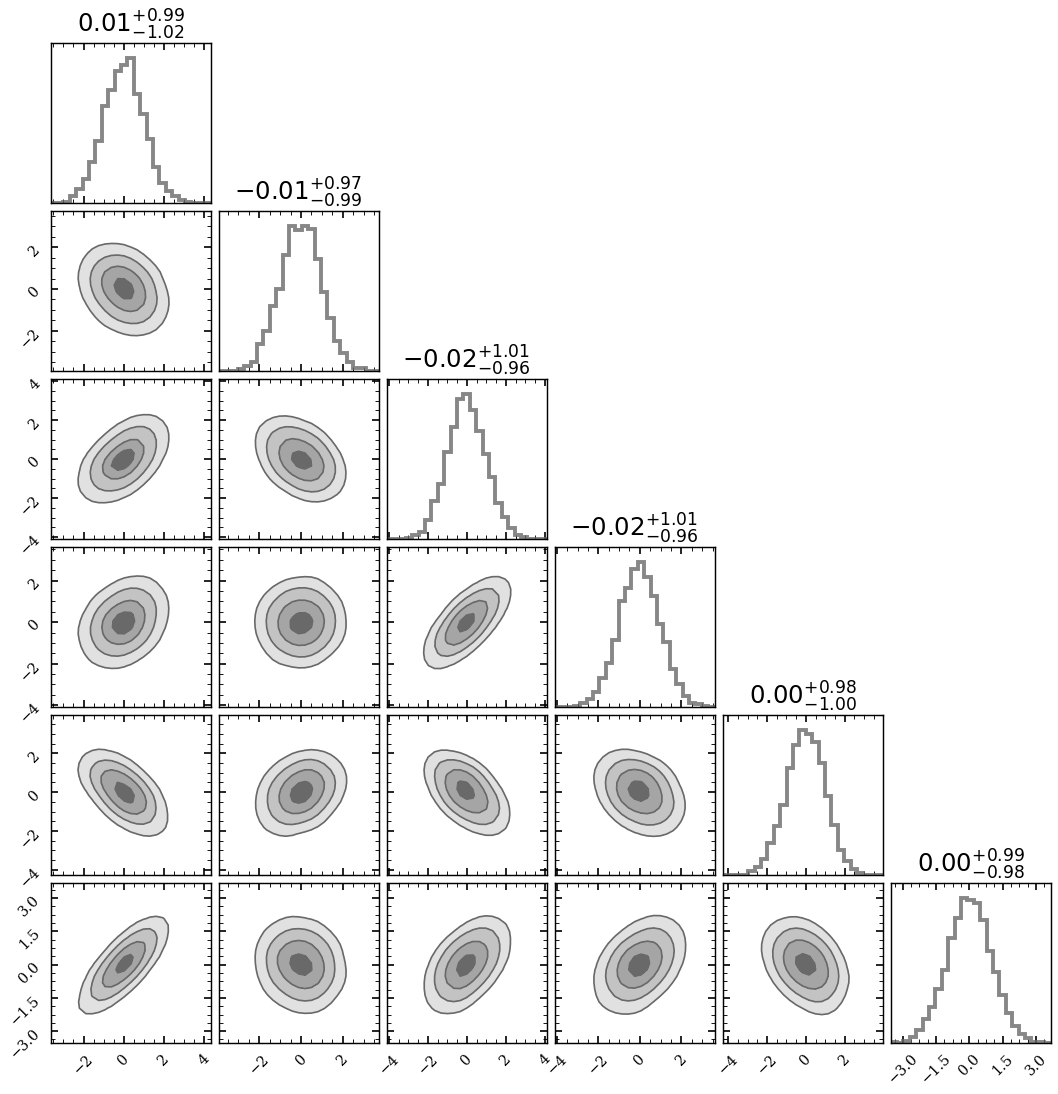

In [90]:
figure = corner.corner(
    sample,
    color='dimgray',
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

## Code is here: You only need things above line 454
https://github.com/AstroJacobLi/popsed/blob/main/popsed/nde.py

In [91]:
from popsed.nde import NeuralDensityEstimator
from sklearn.model_selection import train_test_split
from tqdm import trange

In [92]:
NDE_theta = NeuralDensityEstimator(normalize=True, 
                             initial_pos={'bounds': [[0, 0]] * 6, 'std': [0.05] * 6}, 
                             method='maf')
sample = torch.Tensor(sample).to('cuda')
NDE_theta.build(sample)

[0. 0. 0. 0. 0. 0.]


In [93]:
X_train, X_vali = train_test_split(sample.detach(), test_size=0.1, shuffle=True)

In [94]:
train_loss_history = []
vali_loss_history = []
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3,
                                                steps_per_epoch=100,
                                                epochs=6)
for i, epoch in enumerate(range(6)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    
    t = trange(100,
           desc='Training NDE_theta',
           unit='epochs')
    for epoch in t:
        NDE_theta.optimizer.zero_grad()
        loss = -NDE_theta.net.log_prob(X_train.to('cuda')).mean()
        loss.backward()
        NDE_theta.optimizer.step()
        train_loss_history.append(loss.item())
        
        vali_loss = -NDE_theta.net.log_prob(X_vali.to('cuda')).mean()
        vali_loss_history.append(vali_loss.item())

        t.set_description(
            f'Loss = {loss.item():.3f} (train), {vali_loss.item():.3f} (vali)')
        
        scheduler.step()

    Epoch 0
    lr: 3.9999999999999996e-05


Loss = 11.796 (train), 11.191 (vali): 100%|████████████████████████████| 100/100 [00:02<00:00, 37.45epochs/s]


    Epoch 1
    lr: 0.0006079561997114258


Loss = 4.879 (train), 4.901 (vali): 100%|██████████████████████████████| 100/100 [00:02<00:00, 36.60epochs/s]


    Epoch 2
    lr: 0.0009938441949208876


Loss = 4.574 (train), 4.638 (vali): 100%|██████████████████████████████| 100/100 [00:02<00:00, 37.72epochs/s]


    Epoch 3
    lr: 0.0008088129289961519


Loss = 4.488 (train), 4.577 (vali): 100%|██████████████████████████████| 100/100 [00:02<00:00, 38.00epochs/s]


    Epoch 4
    lr: 0.00045890866416338575


Loss = 4.458 (train), 4.557 (vali): 100%|██████████████████████████████| 100/100 [00:02<00:00, 37.69epochs/s]


    Epoch 5
    lr: 0.0001309439774943247


Loss = 4.453 (train), 4.554 (vali): 100%|██████████████████████████████| 100/100 [00:02<00:00, 37.92epochs/s]


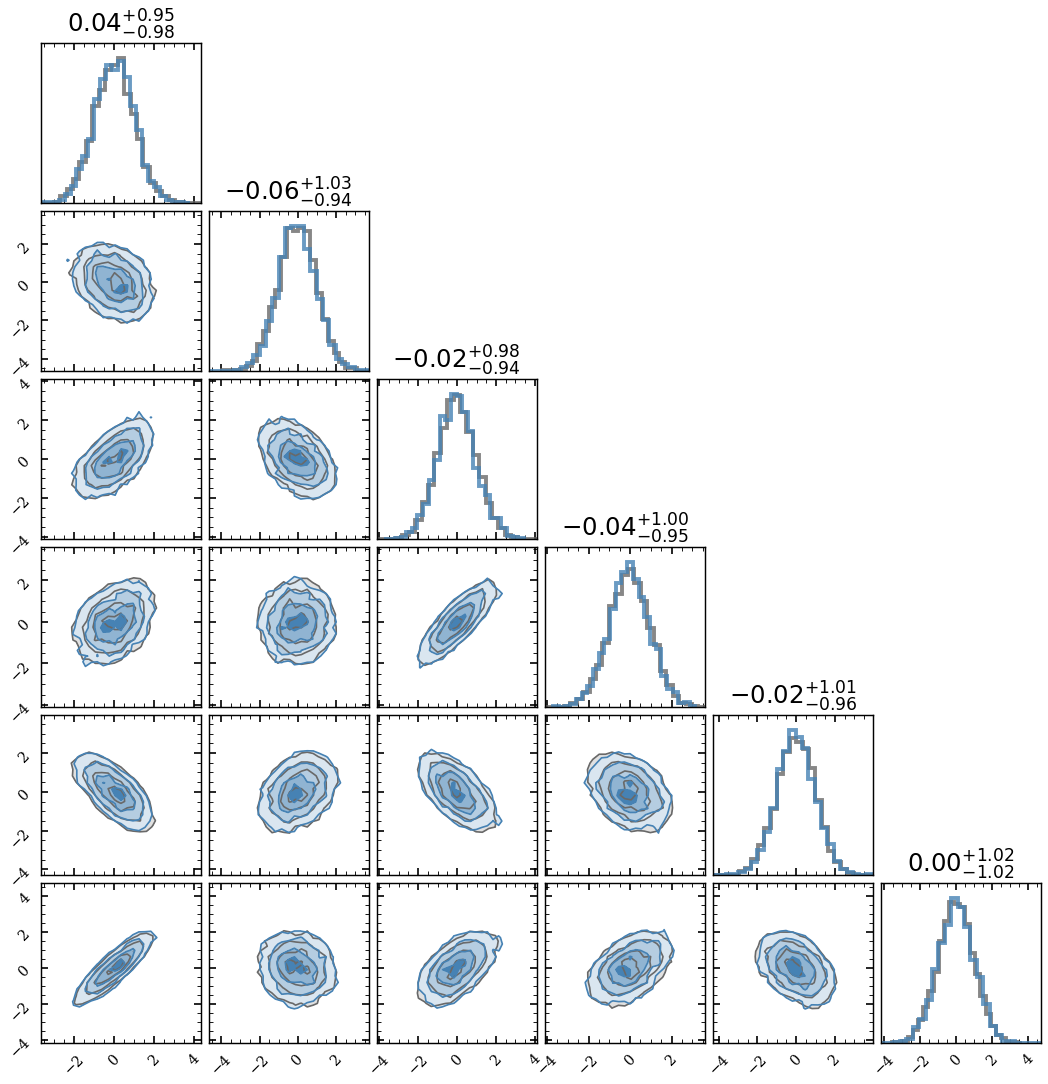

In [95]:
figure = corner.corner(
    sample.cpu().numpy(),
    color='dimgray',
    bins=25,
    smooth=0.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

temp = NDE_theta.sample(3000).detach().cpu().numpy() # This line generates sample using NF
figure = corner.corner(
    temp,
    fig=figure,
    color='steelblue',
    bins=25,
    smooth=0.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

It might be useful to z-score all your data before fitting a normalizing flow. You can use `from popsed.speculator import StandardScaler`